# YELP

In [ ]:

{
  "business_id": "f9NumwFMBDn751xgFiRbNA",
  "name": "The Range At Lake Norman",
  "address": "10913 Bailey Rd",
  "city": "Cornelius",
  "state": "NC",
  "postal_code": "28031",
  "latitude": 35.4627242,
  "longitude": -80.8526119,
  "stars": 3.5,
  "review_count": 36,
  "is_open": 1,
  "attributes": {
    "BusinessAcceptsCreditCards": "True",
    "BikeParking": "True",
    "GoodForKids": "False",
    "BusinessParking": "{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}",
    "ByAppointmentOnly": "False",
    "RestaurantsPriceRange2": "3"
  },
  "categories": "Active Life, Gun/Rifle Ranges, Guns & Ammo, Shopping",
  "hours": {
    "Monday": "10:0-18:0",
    "Tuesday": "11:0-20:0",
    "Wednesday": "10:0-18:0",
    "Thursday": "11:0-20:0",
    "Friday": "11:0-20:0",
    "Saturday": "11:0-20:0",
    "Sunday": "13:0-18:0"
  }
}


字段名称 含义 数据格式 例子

business_id 商家ID string “business_id”: “tnhfDv5Il8EaGSXZGiuQGg”

name 商家名称 string “name”: “Garaje”

address 商家地址 string “address”: “475 3rd St”

city 商家所在城市 string “city”: “San Francisco”

state 商家所在洲 string “state”: “CA”

postal code 邮编 string “postal code”: “94107”

latitude 维度 float “latitude”: 37.7817529521

longitude 经度 float “longitude”: -122.39612197

stars 星级评分 float “stars”: 4.5

review_count 评论个数 integer “review_count”: 1198

is_open 商家是否营业

0：关闭， 1：营业 integer “is_open”: 1

attributes 商家业务(外卖，business parking) object “attributes”: {
“RestaurantsTakeOut”: true,
“BusinessParking”: {
“garage”: false,
“street”: true,
“validated”: false,
“lot”: false,
“valet”: false
},
}

categories 商家所属类别 array “categories”: [
“Mexican”,
“Burgers”,
“Gastropubs”
]

hours 商家营业时间 dict “hours”: {
“Monday”: “10:00-21:00”,
“Tuesday”: “10:00-21:00”,
“Friday”: “10:00-21:00”,
“Wednesday”: “10:00-21:00”,
“Thursday”: “10:00-21:00”,
“Sunday”: “11:00-18:00”,
“Saturday”: “10:00-21:00”
}

In [37]:
import os

In [2]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as func

conf = SparkConf().setAppName('YELP').setMaster("local[4]")
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [3]:
spark

In [6]:
business = spark.read.json('./yelp_academic_dataset_business.json')
business.show(2)

+--------------------+--------------------+--------------------+--------------------+----------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|      city|               hours|is_open|  latitude|   longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+----------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|     10913 Bailey Rd|[,,,,,,, True,, T...|f9NumwFMBDn751xgF...|Active Life, Gun/...| Cornelius|[11:0-20:0, 10:0-...|      1|35.4627242| -80.8526119|The Range At Lake...|      28031|          36|  3.5|   NC|
|8880 E Via Linda,...|[,,,,,,,,,,, True...|Yzvjg0SayhoZgCljU...|Health & Medical,...|Scottsdale|                null|      1|33.5694041|-111.8902637|   Carlos Santo, NM

In [7]:
# 将 `categories`列展开 成list
split_col = func.split(business['categories'], ',')
business = business.withColumn("categories", split_col).filter(business["city"] != '').dropna()

In [8]:
business.columns

['address',
 'attributes',
 'business_id',
 'categories',
 'city',
 'hours',
 'is_open',
 'latitude',
 'longitude',
 'name',
 'postal_code',
 'review_count',
 'stars',
 'state']

In [9]:
business.show(1)

+---------------+--------------------+--------------------+--------------------+---------+--------------------+-------+----------+-----------+--------------------+-----------+------------+-----+-----+
|        address|          attributes|         business_id|          categories|     city|               hours|is_open|  latitude|  longitude|                name|postal_code|review_count|stars|state|
+---------------+--------------------+--------------------+--------------------+---------+--------------------+-------+----------+-----------+--------------------+-----------+------------+-----+-----+
|10913 Bailey Rd|[,,,,,,, True,, T...|f9NumwFMBDn751xgF...|[Active Life,  Gu...|Cornelius|[11:0-20:0, 10:0-...|      1|35.4627242|-80.8526119|The Range At Lake...|      28031|          36|  3.5|   NC|
+---------------+--------------------+--------------------+--------------------+---------+--------------------+-------+----------+-----------+--------------------+-----------+------------+-----+--

In [11]:
business.createOrReplaceTempView('business')

In [14]:
b_etl = spark.sql("select business_id, name, city, state, latitude, longitude, stars, review_count, is_open, categories, attributes from business").cache()

# 1. 离群点

In [15]:
b_etl.createOrReplaceTempView('b_etl')

In [16]:
# 离群点  距离洲内商家平均位置的欧式距离
outlier = spark.sql("""
    SELECT 
        b1.business_id,
        SQRT(POWER(b1.latitude - b2.avg_lat, 2) + POWER(b1.longitude - b2.avg_long, 2)) as dist
    FROM 
        b_etl b1
    INNER JOIN 
        (
            SELECT 
                state, AVG(latitude) as avg_lat, AVG(longitude) as avg_long
            FROM
                b_etl
            GROUP BY
                state
        ) b2

    ON
        b1.state = b2.state
    ORDER BY 
        dist DESC
""")

In [17]:
outlier.createOrReplaceTempView("outlier")

In [19]:
# 保留距离小于10的
joined = spark.sql("""
    SELECT 
        b.* 
    FROM 
        b_etl b 
    INNER JOIN 
        outlier o 
    ON 
        b.business_id = o.business_id 
    WHERE
        o.dist < 10
""")

In [20]:
joined.write.parquet("file:///mnt/data1/workspace/data_analysis_mining/Python_Spark/demo/result_yelp/business_etl", mode="overwrite")

# 2. 数据分析

In [38]:
RESULT_DIR = "file:///mnt/data1/workspace/data_analysis_mining/Python_Spark/demo/result_yelp"

In [26]:
data_path = os.path.join(RESULT_DIR, 'business_etl')
business = spark.read.parquet(data_path).cache()
business.createOrReplaceTempView("business")

In [27]:
# explode 行list -> 列
part_business = spark.sql("SELECT state, city, stars, review_count, explode(categories) AS category FROM business").cache()
part_business.show()


+-----+----------------+-----+------------+--------------------+
|state|            city|stars|review_count|            category|
+-----+----------------+-----+------------+--------------------+
|   AZ|         Phoenix|  4.0|          41|            Notaries|
|   AZ|         Phoenix|  4.0|          41|     Mailbox Centers|
|   AZ|         Phoenix|  4.0|          41|   Printing Services|
|   AZ|         Phoenix|  4.0|          41|      Local Services|
|   AZ|         Phoenix|  4.0|          41|    Shipping Centers|
|   NV|       Las Vegas|  4.0|         681|         Restaurants|
|   NV|       Las Vegas|  4.0|         681|                Bars|
|   NV|       Las Vegas|  4.0|         681|           Nightlife|
|   NV|       Las Vegas|  4.0|         681|      American (New)|
|   NV|       Las Vegas|  4.0|         681|             Seafood|
|   QC|Vaudreuil-Dorion|  4.0|           7|                Food|
|   QC|Vaudreuil-Dorion|  4.0|           7|            Bakeries|
|   AZ|      Scottsdale| 

In [28]:
part_business.createOrReplaceTempView("part_business_1")

In [55]:
# 把空格去掉
part_business = spark.sql("select state, city , stars, review_count, REPLACE(category, ' ', '') as new_category from part_business_1")
part_business.show()

+-----+----------------+-----+------------+-------------------+
|state|            city|stars|review_count|       new_category|
+-----+----------------+-----+------------+-------------------+
|   AZ|         Phoenix|  4.0|          41|           Notaries|
|   AZ|         Phoenix|  4.0|          41|     MailboxCenters|
|   AZ|         Phoenix|  4.0|          41|   PrintingServices|
|   AZ|         Phoenix|  4.0|          41|      LocalServices|
|   AZ|         Phoenix|  4.0|          41|    ShippingCenters|
|   NV|       Las Vegas|  4.0|         681|        Restaurants|
|   NV|       Las Vegas|  4.0|         681|               Bars|
|   NV|       Las Vegas|  4.0|         681|          Nightlife|
|   NV|       Las Vegas|  4.0|         681|      American(New)|
|   NV|       Las Vegas|  4.0|         681|            Seafood|
|   QC|Vaudreuil-Dorion|  4.0|           7|               Food|
|   QC|Vaudreuil-Dorion|  4.0|           7|           Bakeries|
|   AZ|      Scottsdale|  3.5|          

In [56]:
part_business.createOrReplaceTempView("part_business")

In [31]:
all_categories = spark.sql("select business_id, explode(categories) AS category FROM business")
all_categories.createOrReplaceTempView("all_categories")

查看有多少中不同的分类


In [34]:
all_categories.show()

+--------------------+--------------------+
|         business_id|            category|
+--------------------+--------------------+
|-2YIg-PAgCMXMLxw5...|            Notaries|
|-2YIg-PAgCMXMLxw5...|     Mailbox Centers|
|-2YIg-PAgCMXMLxw5...|   Printing Services|
|-2YIg-PAgCMXMLxw5...|      Local Services|
|-2YIg-PAgCMXMLxw5...|    Shipping Centers|
|-3zffZUHoY8bQjGfP...|         Restaurants|
|-3zffZUHoY8bQjGfP...|                Bars|
|-3zffZUHoY8bQjGfP...|           Nightlife|
|-3zffZUHoY8bQjGfP...|      American (New)|
|-3zffZUHoY8bQjGfP...|             Seafood|
|-5IV_IrH5D7hyip2P...|                Food|
|-5IV_IrH5D7hyip2P...|            Bakeries|
|-5QWiL1jpzQDpQSVy...|            Shopping|
|-5QWiL1jpzQDpQSVy...|       Home & Garden|
|-5QWiL1jpzQDpQSVy...|          Mattresses|
|-5y5m3v_5ZHwlXwsp...|                Gyms|
|-5y5m3v_5ZHwlXwsp...|        Sports Clubs|
|-5y5m3v_5ZHwlXwsp...|         Active Life|
|-5y5m3v_5ZHwlXwsp...| Fitness & Instru...|
|-80pfkoY1Br4BrcGj...|         R

In [33]:
print("查看有多少中不同的分类")
distinct = spark.sql("select count(distinct(new_category)) from  part_business")
distinct.show()

查看有多少中不同的分类
+----------------------------+
|count(DISTINCT new_category)|
+----------------------------+
|                        1318|
+----------------------------+



In [36]:
# 美国10种主要的商业类别
print("## Top 10 business categories")
top_cat = spark.sql("select new_category, count(*) as num from part_business group by new_category order by num desc limit 10")
top_cat.show()

## Top 10 business categories
+--------------+-----+
|  new_category|  num|
+--------------+-----+
|   Restaurants|49936|
|      Shopping|27014|
|          Food|25985|
|  HomeServices|16880|
|   Beauty&Spas|16607|
|Health&Medical|14843|
| LocalServices|12003|
|     Nightlife|11614|
|          Bars|10448|
|    Automotive| 9166|
+--------------+-----+



In [39]:
top_cat.write.json(os.path.join(RESULT_DIR, 'top_category'))

In [44]:
# 每个城市各种商业类型的商家数量
print("## Top business categories - in every city")
top_cate_city = spark.sql("""
    SELECT 
        city, new_category, COUNT(*) as num
    FROM
        part_business
    GROUP BY
        city, new_category
    ORDER BY
        num DESC
""")
top_cate_city.show()

## Top business categories - in every city
+----------+--------------+----+
|      city|  new_category| num|
+----------+--------------+----+
|   Toronto|   Restaurants|6573|
| Las Vegas|   Restaurants|5573|
| Las Vegas|      Shopping|4334|
|   Toronto|          Food|3453|
|   Phoenix|   Restaurants|3314|
| Las Vegas|  HomeServices|3298|
| Las Vegas|          Food|3134|
|  Montréal|   Restaurants|3130|
| Las Vegas|   Beauty&Spas|2826|
|   Phoenix|      Shopping|2733|
|   Phoenix|  HomeServices|2682|
| Las Vegas|Health&Medical|2669|
|   Toronto|      Shopping|2463|
| Charlotte|   Restaurants|2425|
|   Calgary|   Restaurants|2366|
| Las Vegas| LocalServices|2300|
|Pittsburgh|   Restaurants|2133|
|   Phoenix|          Food|1877|
|   Phoenix|Health&Medical|1829|
| Las Vegas|     Nightlife|1747|
+----------+--------------+----+
only showing top 20 rows



In [45]:
top_cate_city.write.json(os.path.join(RESULT_DIR, 'top_city_cate'), mode='overwrite')

In [50]:
# 商家数量最多的10个城市  数business_id 
bus_city = spark.sql("""
    SELECT
        city, COUNT(business_id) as num
    FROM
        business
    GROUP BY
        city
    ORDER BY
        num DESC
    LIMIT
        10
""")
bus_city.show()

+----------+-----+
|      city|  num|
+----------+-----+
| Las Vegas|22554|
|   Phoenix|14186|
|   Toronto|13602|
| Charlotte| 7487|
|Scottsdale| 6955|
|Pittsburgh| 5383|
|   Calgary| 5260|
|  Montréal| 4935|
|      Mesa| 4850|
| Henderson| 3833|
+----------+-----+



In [51]:
bus_city.write.json(os.path.join(RESULT_DIR, "bus_city"), mode="overwrite")

In [52]:
# 消费者评价最多的10种商业类别
top_review_count = spark.sql("""
    SELECT 
        new_category, AVG(review_count) as avg_review_count
    FROM
        part_business
    GROUP BY
        new_category
    ORDER BY
        avg_review_count DESC
    LIMIT
        10
""")
top_review_count.show()

+-----------------+------------------+
|     new_category|  avg_review_count|
+-----------------+------------------+
|        StreetArt|            1253.0|
|     MarketStalls|            1084.0|
|       BeerGarden|            1063.5|
|          Resorts| 489.8606060606061|
|             Udon|             462.0|
|           Tuscan|             446.6|
|          Casinos|440.74581005586595|
|ConveyorBeltSushi|             410.5|
|         Pancakes| 333.1111111111111|
|         TikiBars| 329.3333333333333|
+-----------------+------------------+



In [53]:
top_review_count.write.json(os.path.join(RESULT_DIR, 'top_review_count'), mode="overwrite")


In [57]:
# 最受消费者喜欢的前10种商业类型 平均星级评分最高
top_stars = spark.sql("""
    SELECT
        new_category, AVG(stars) as avg_stars
    FROM
        part_business
    GROUP BY
        new_category
    ORDER BY
        avg_stars DESC
""")
top_stars.show(10)

+--------------------+-----------------+
|        new_category|        avg_stars|
+--------------------+-----------------+
|         Stonemasons|              5.0|
|    EntertainmentLaw|              5.0|
|WildlifeHuntingRa...|              5.0|
|      JapaneseSweets|              5.0|
|      CourtReporters|              5.0|
|       OutdoorMovies|              5.0|
|    SignatureCuisine|              5.0|
|     GameTruckRental|4.928571428571429|
|           PublicArt|4.916666666666667|
|  BrazilianJiu-jitsu|4.882352941176471|
+--------------------+-----------------+
only showing top 10 rows



In [58]:
top_stars.write.json(os.path.join(RESULT_DIR, 'top_stars'), mode="overwrite")

In [ ]:
spark.sql("select ")

In [80]:
def attribute_score(attribute):

    att = spark.sql(
        "select attributes.{attr} as {attr}, category, stars from for_att".format(attr=attribute)
    ).dropna()
    att.createOrReplaceTempView('att')
    att_group = spark.sql(
        "select {attr}, AVG(stars) as stars from att group by {attr} order by stars".format(attr=attribute)
    )
    att_group.show()
    att_group.write.json(
        os.path.join(RESULT_DIR, '{}'.format(attribute)),
        mode='overwrite')

In [66]:
# 商业额外业务的评价情况
# 该项对商家是否有’Take out’服务进行分析，统计出两种不同情况的商家的平均星级评分.
for_att = spark.sql("SELECT attributes, stars, explode(categories) AS category FROM business")
for_att.createOrReplaceTempView("for_att")
attribute = "RestaurantsTakeout"


In [83]:
# 可能为null
spark.sql("select distinct(attributes.RestaurantsTakeout) from for_att").show(10, truncate=False)

+------------------+
|RestaurantsTakeout|
+------------------+
|None              |
|False             |
|null              |
|True              |
+------------------+



In [81]:
attribute_score(attribute)

+------------------+-----------------+
|RestaurantsTakeout|            stars|
+------------------+-----------------+
|              True|3.543621136355401|
|             False|3.614546070715819|
|              None|3.640769230769231|
+------------------+-----------------+



# 可视化

In [18]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['font.size'] = 20
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['figure.figsize'] = [8, 6]
# ['Noto Sans CJK JP']  SimHei
plt.rcParams['font.family'] = ['Noto Sans CJK JP']
plt.rcParams['axes.unicode_minus'] = False

In [29]:
RESULT_DIR = "/mnt/data1/workspace/data_analysis_mining/Python_Spark/demo/result_yelp"

TOP_CATEGORY = os.path.join(RESULT_DIR, "op_category")  # 10种主要的商业类别
TOP_BUSINESS_CITY = os.path.join(RESULT_DIR, "bus_city")  # 每个城市各种商业类型的商家数量
TAKEOUT = os.path.join(RESULT_DIR, "RestaurantsTakeout")

In [2]:
def read_json(file_path):
    json_paths = os.listdir(file_path)
    data = []
    for path in json_paths:
        if path.endswith('.json'):
            name = os.path.join(file_path, path)
            with open(name) as f:
                for line in f:
                    data.append(json.loads(line))
    return data

In [10]:
top_cat_list = read_json(TOP_CATEGORY)

In [11]:
top_cat_list[0]

{'new_category': 'Restaurants', 'num': 49936}

In [12]:
# 重新读取json文件后 再次排序
top_cat_list.sort(key=lambda x: x['num'], reverse=True)
top_category_key = []
top_category_value = []
for i in range(10):
    one = top_cat_list[i]
    top_category_key.append(one['new_category'])
    top_category_value.append(one['num'])

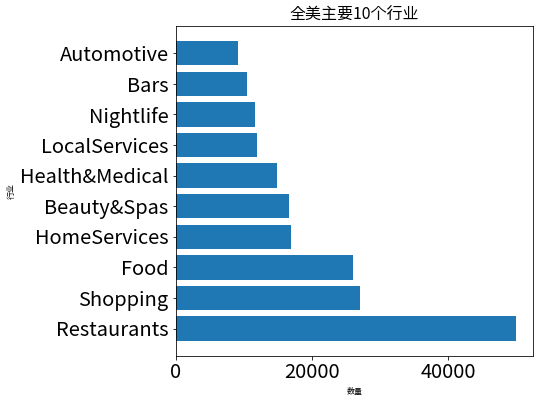

In [19]:
plt.barh(
    top_category_key, 
    top_category_value,
    tick_label=top_category_key
    )
plt.title("全美主要10个行业", size=16)
plt.xlabel('数量',size =8, color = 'Black')
plt.ylabel('行业',size =8, color = 'Black')
plt.tight_layout()

In [21]:
# 每个城市各种商业类型的商家数量
top_business_city_list = read_json(TOP_BUSINESS_CITY)
top_business_city_list[0]

{'city': 'Las Vegas', 'num': 22554}

In [23]:
top_business_city_list.sort(key=lambda x: x['num'], reverse=True)

top_business_city_key = []
top_business_city_value = []
for i in range(10):
    one = top_business_city_list[i]
    top_business_city_key.append(one['city'])
    top_business_city_value.append(one['num'])

In [25]:
top_business_city_value

[22554, 14186, 13602, 7487, 6955, 5383, 5260, 4935, 4850, 3833]

In [26]:
top_business_city_key

['Las Vegas',
 'Phoenix',
 'Toronto',
 'Charlotte',
 'Scottsdale',
 'Pittsburgh',
 'Calgary',
 'Montréal',
 'Mesa',
 'Henderson']

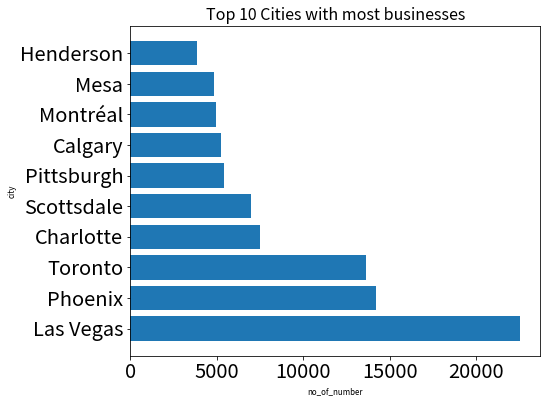

In [28]:
plt.barh(
     top_business_city_key[:10],   
     top_business_city_value[:10],
     tick_label=top_business_city_key[:10])

plt.title('Top 10 Cities with most businesses', size = 16)
plt.xlabel('no_of_number',size =8, color = 'Black')
plt.ylabel('city',size = 8, color = 'Black')
plt.tight_layout()

In [30]:
takeout_list = read_json(TAKEOUT)
takeout_list

[{'RestaurantsTakeout': 'True', 'stars': 3.543621136355401},
 {'RestaurantsTakeout': 'False', 'stars': 3.614546070715819},
 {'RestaurantsTakeout': 'None', 'stars': 3.640769230769231}]

In [31]:
takeout_list.sort(key=lambda x: x['stars'], reverse=True)
takeout_key = []
takeout_value = []
for idx in range(len(takeout_list)):
    one = takeout_list[idx]
    takeout_key.append(one['stars'])
    takeout_value.append(one['RestaurantsTakeout'])

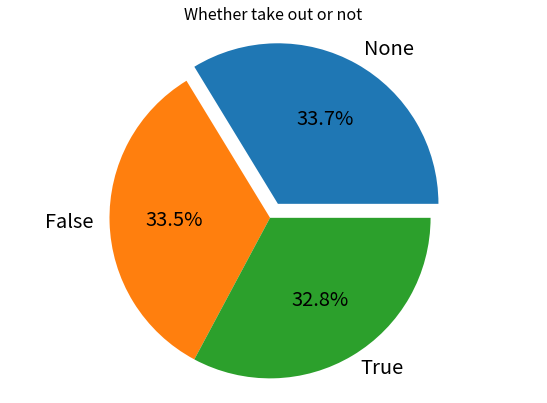

In [37]:
explode=(0.1, 0, 0)
plt.pie(takeout_key, 
        explode=explode,
        labels=takeout_value,
        autopct="%1.1f%%")
plt.title('Whether take out or not', size=16)
plt.axis('equal')
plt.tight_layout()